# Аналитический кейс для стартапа (интернет-магазин продуктов питания)

1. [**Подготовка данных к анализу.**](#100101)
2. [**Изучение и проверка данных.**](#100102)
    * [2.1.Сколько всего событий в логе?](#102100)
    * [2.2.Сколько всего пользователей в логе?](#102101)
    * [2.3.Сколько в среднем событий приходится на пользователя?](#102102)
    * [2.4.Данными за какой период мы располагаем? Можно ли быть уверенными, что у нас одинаково полные данные за весь период? Если нет, то данными за какой период мы располагаем на самом деле?](#102103)
    * [2.5.Много ли событий и пользователей мы потеряли, отбросив неактуальные данные?](#102104)
    * [2.6.Точно ли остались пользователи из всех трёх экспериментальных групп?](#102105)
3. [**Изучение воронки событий.**](#100103)
    * [3.1.Какие события есть в логах, как часто они встречаются? (Отсортируем события по частоте).](#103100)
    * [3.2.Посчитаем количество пользователей, которые совершили каждое из этих событий.](#103101)
    * [3.3.В какой последовательности события происходят в приложении? Все ли события выстраиваются в последовательную цепочку?](#103102)
    * [3.4.Воронка событий. Какая доля пользователей проходит на следующий шаг воронки?](#103103)
    * [3.5.На каком шаге теряем больше всего пользователей?](#103104)
    * [3.6.Какая доля пользователей доходит от первого события до оплаты?](#103105)
4. [**Изучение результатов эксперимента.**](#100104)
    * [4.1.Сколько пользователей в каждой экспериментальной группе?](#104100)
    * [4.2.По 2-м контрольным групам для А/А эксперимента проверим находят ли статистические критерии разницу между выборками 246 и 247?](#104101)
    * [4.3.Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп и долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. То же для всех других событий. Можно ли сказать, что разбиение на группы работает корректно?](#104102)
    * [4.4.Аналогично для 248 группы. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?](#104103)
5. [**Выводы.**](#100105)

## 1. Подготовка данных к анализу. <a id='100101'></a>

In [49]:
import pandas as pd
import re
path = 'logs_exp.csv'
prod = pd.read_csv(path, delimiter=',')

from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns

from pandas.plotting import register_matplotlib_converters
pd.options.mode.chained_assignment = None
pd.options.display.max_colwidth = 100
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000)

In [50]:
#посмотрим на информацию о данных:
prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [51]:
#посмотрим на сами данные:
prod.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [52]:
#переименуем названия колонок, для удобства:
prod.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
#prod.head()

In [53]:
#поменяем тип колонки device_id_hash  и exp_id на object, т.к. это id:
prod['device_id_hash'] = prod['device_id_hash'].astype(object)
prod['exp_id'] = prod ['exp_id'].astype(object)
#проверим:
#prod.info()

In [54]:
#переведем время в формате UTC в обычную дату и время:
prod['event_timestamp'] = (pd.to_datetime(prod['event_timestamp'],unit='s'))

#добавим дополнительно столбец даты:
prod['date'] = prod['event_timestamp'].dt.strftime('%Y-%m-%d')
#проверим:
prod.head()

,event_name,device_id_hash,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


_______________________

**Исследуем данные:**

In [55]:
#посмотрим есть ли незаполненные ячейки:
prod.isnull().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
date               0
dtype: int64

Пропусков нет.

_________________________________

## 2. Изучение и проверка данных. <a id='100102'></a>

### 2.1.Сколько всего событий в логе? <a id='102100'></a>

In [56]:
event = prod['event_name'].value_counts().sum()
event

244126

Событий столько же сколько и строк в таблице.

In [57]:
#узнаем количество уникальных значений в столбце event_name:
obj = prod['event_name'].value_counts()
obj

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event_name, dtype: int64

5 типов событий. Похоже на продуктовую воронку ).

___________________________

### 2.2.Сколько всего пользователей в логе? <a id='102101'></a>

In [58]:
user = prod['device_id_hash'].value_counts().count()
user

7551

_________________________

### 2.3.Сколько в среднем событий приходится на пользователя? <a id='102102'></a>

In [59]:
prod['device_id_hash'].value_counts().mean()
print('В среднем', (event/user).round(), 'событий на пользователя')

В среднем 32.0 событий на пользователя


*******************

### 2.4.Данными за какой период мы располагаем? Можно ли быть уверенными, что у нас одинаково полные данные за весь период? Если нет, то данными за какой период мы располагаем на самом деле? <a id='102103'></a>

In [60]:
prod.describe()

,event_name,device_id_hash,event_timestamp,exp_id,date
count,244126,2.441260e+05,244126,244126.0,244126
unique,5,7.551000e+03,176654,3.0,14
top,MainScreenAppear,6.304868e+18,2019-08-04 16:23:19,248.0,2019-08-01
freq,119205,2.308000e+03,9,85747.0,36229
first,NaN,NaN,2019-07-25 04:43:36,NaN,NaN
last,NaN,NaN,2019-08-07 21:15:17,NaN,NaN


Первая дата 04:43:36 25 июля 2019 года последняя - 21:15:17 7 августа 2019 года. Наиболее распространенное событие main screen appear (посещение главной страницы) таких событий 119205 - 49% от всех событий. Больше всего событий произошло 1 августа 2019 года - 14,8% от всех.

_Построим график по датам:_

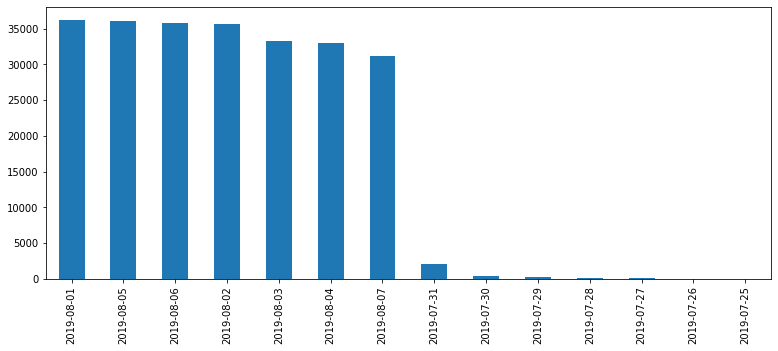

In [61]:
dat = prod['date'].value_counts()
dat.plot(kind='bar', figsize=(13, 5))

В реальности данные о событиях есть с 27 июля 2019 по 7 августа 2019.

_______________________________

### 2.5.Много ли событий и пользователей мы потеряли, отбросив неактуальные данные? <a id='102104'></a>

_Сделаем срез с реальными данными._

In [62]:
prod_real = prod.query('date >= "2019-07-27" and date <= "2019-08-07"')
#посмотрим на данные теперь:
prod_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244086 entries, 40 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       244086 non-null  object        
 1   device_id_hash   244086 non-null  object        
 2   event_timestamp  244086 non-null  datetime64[ns]
 3   exp_id           244086 non-null  object        
 4   date             244086 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 11.2+ MB


"Ушёл" 1% данных.

_________________________________________

### 2.6.Точно ли остались пользователи из всех трёх экспериментальных групп? <a id='102105'></a>

In [63]:
prod_real['exp_id'].value_counts()

248    85734
246    80286
247    78066
Name: exp_id, dtype: int64

Пользователи из всех трех групп есть, но группы не равны.

___________________________

## 3. Изучение воронки событий. <a id='100103'></a>

### 3.1.Какие события есть в логах, как часто они встречаются? (Отсортируем события по частоте). <a id='103100'></a>

In [64]:
prod_real['event_name'].value_counts()

MainScreenAppear           119185
OffersScreenAppear          46820
CartScreenAppear            42723
PaymentScreenSuccessful     34308
Tutorial                     1050
Name: event_name, dtype: int64

Чаще всего встречается заход на Главную страницу - 49% от всех событий.

__________________________

### 3.2.Посчитаем количество пользователей, которые совершили каждое из этих событий. Посчитаем долю пользователей, которые хоть раз совершали событие. <a id='103101'></a>

In [65]:
sum_event_user = prod_real['device_id_hash'].count()
sum_event_user

244086

In [66]:
user_grouped = prod_real.groupby('event_name', as_index=False).agg({'device_id_hash' : 'count'})
user_grouped['share_user'] = user_grouped['device_id_hash'] / sum_event_user
user_grouped

,event_name,device_id_hash,share_user
0,CartScreenAppear,42723,0.175033
1,MainScreenAppear,119185,0.488291
2,OffersScreenAppear,46820,0.191818
3,PaymentScreenSuccessful,34308,0.140557
4,Tutorial,1050,0.004302


__________________

### 3.3.В какой последовательности события происходят в приложении? Все ли события выстраиваются в последовательную цепочку? <a id='103102'></a>

In [67]:
prod_real['event_name'].value_counts()

MainScreenAppear           119185
OffersScreenAppear          46820
CartScreenAppear            42723
PaymentScreenSuccessful     34308
Tutorial                     1050
Name: event_name, dtype: int64

Ранее уже сортировали события: заход на главную страницу (MainScreenAppear) - 119185, переход на страницу товара(OffersScreenAppear) - 46820, добавление товара в корзину(CartScreenAppear) - 42723, оплата товара(PaymentScreenSuccessful) - 34308. А вот Tutorial (состав, скорее всего или условия доставки) - неизвестно на каком этапе просматривается пользователем в начале или в конце, в последовательную цепочку оно не входит.

_________________________________________

### 3.4.Воронка событий. Какая доля пользователей проходит на следующий шаг воронки? <a id='103103'></a>

_Возьмем все события без Tutorial, т.к. прямого отношения к воронке оно не имеет._

In [68]:
fig = go.Figure(go.Funnel(
    y = ["MainScreenAppear", "OffersScreenAppear", "CartScreenAppear", "PaymentScreenSuccessful"],
    x = [119185, 46820,  42723, 34308]
    ))
fig.show()

__________________________________

### 3.5.На каком шаге теряем больше всего пользователей? <a id='103104'></a>

Наибольшие потери происходят на этапе перехода/поиска товара - 39,3%. Возможно есть трудности с поиском товара на сайте. **Обратить внимание коллег!**

____________________________

### 3.6.Какая доля пользователей доходит от первого события до оплаты? <a id='103105'></a>

28,8% пользователей доходят до оплаты после захода на Главную страницу.

_События совершенные клиентами по датам:_

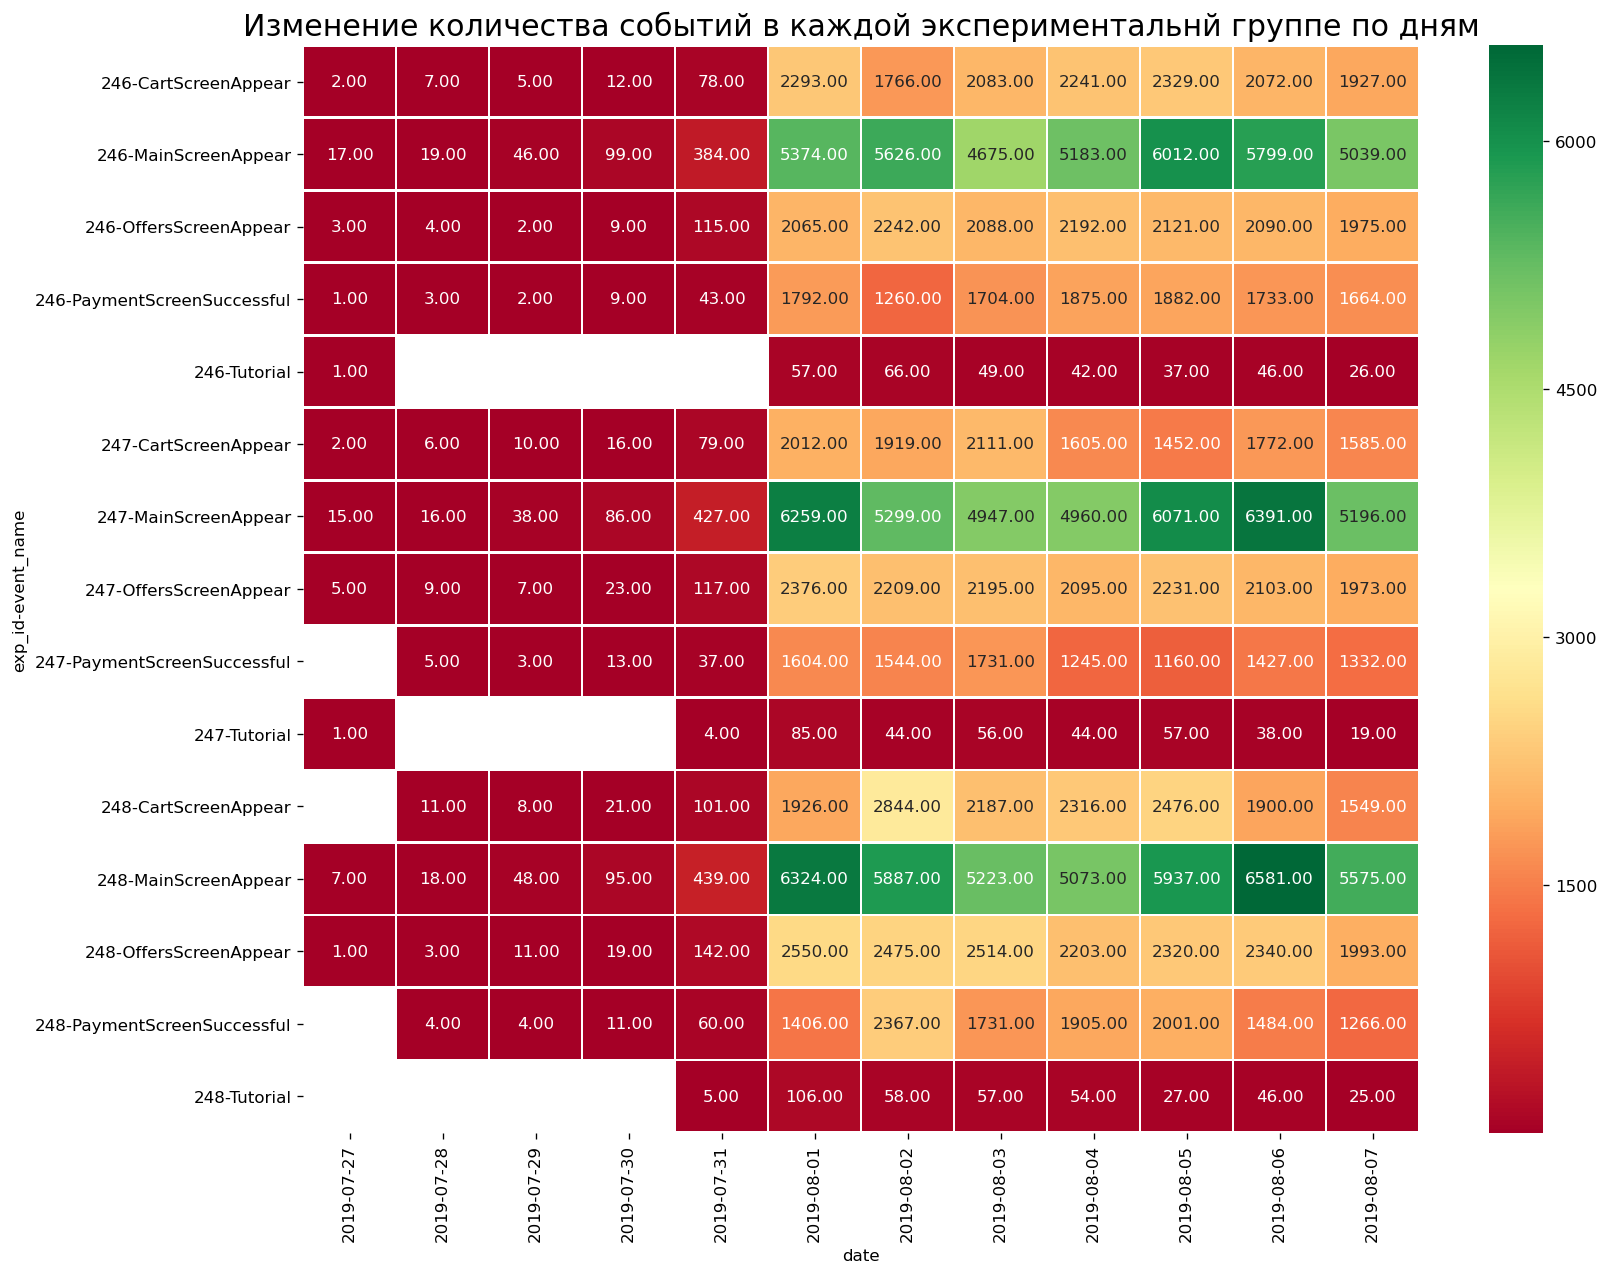

In [69]:
v9 = prod_real.pivot_table(index=['exp_id', 'event_name'], columns=['date'], values='device_id_hash', aggfunc='count')
plt.figure(figsize=(15,12), dpi= 120)
plt.title('Изменение количества событий в каждой экспериментальнй группе по дням', fontsize=18) 
sns.heatmap(v9, annot=True, fmt='.2f', linewidths=1, linecolor='white', cmap='RdYlGn')

**С 1 авуста 2019 наблюдается резкий приток пользователей на сайт во всех группах. Причем первое событие - заход на Главную страницу в лидерах, возможно это старт рекламной кампании.**

_Посмотрим по контрольным и экспериментальной группам на покупки._

In [70]:
v10 = prod_real.pivot_table(index=['date'], columns=['exp_id', 'event_name'], values='device_id_hash', aggfunc='count').reset_index()
v10.columns = ['date', '246_cart', '246_main', '246_offers', '246_pay', '246_tutorial', '247_cart', '247_main', '247_offers', '247_pay', '247_tutorial', '248_cart', '248_main', '248_offers', '248_pay', '248_tutorial']
v10 = v10.fillna(0)
v11 = v10[['date', '246_main', '246_pay', '247_main', '247_pay', '248_main', '248_pay']]

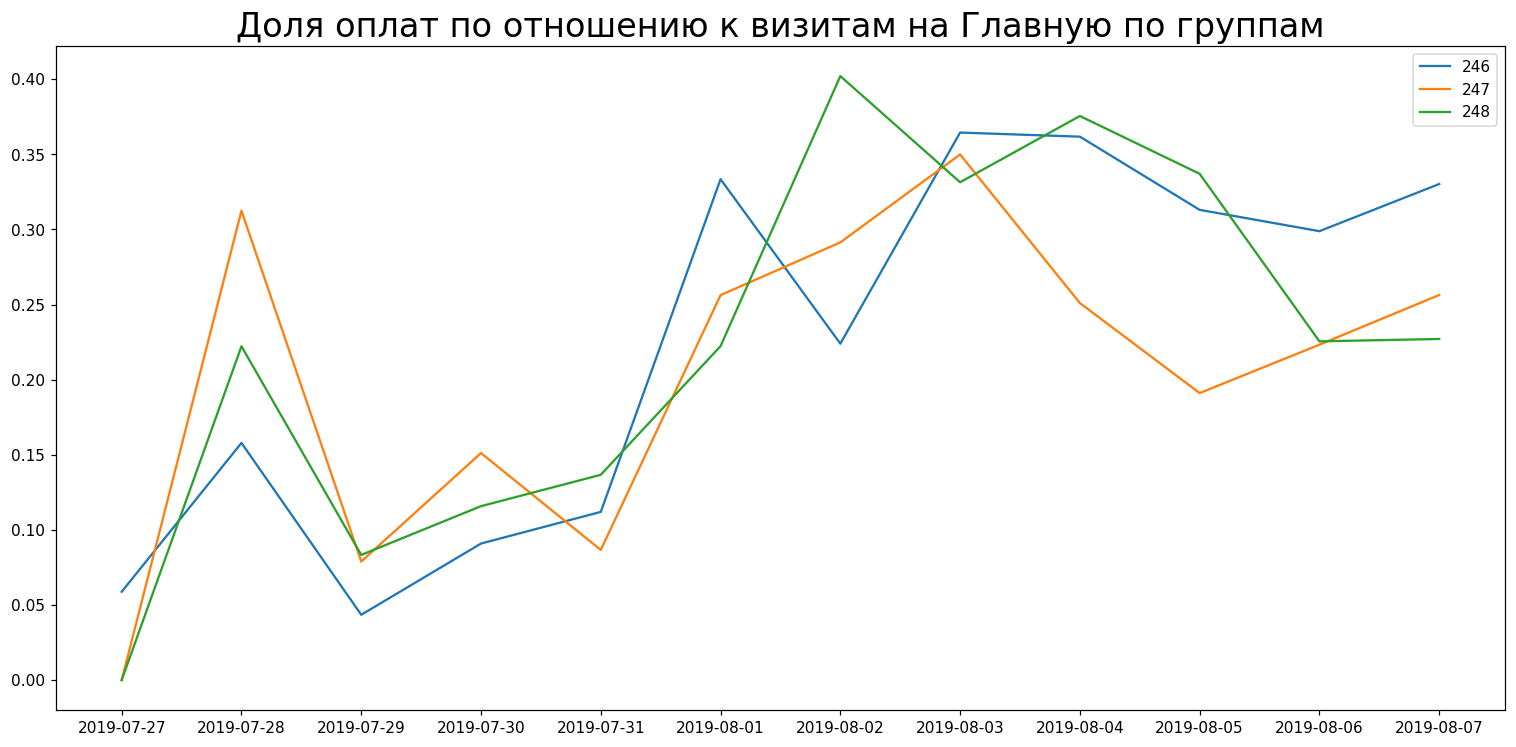

In [71]:
plt.figure(figsize=(17, 8), dpi=110)

plt.plot(v11['date'], v11['246_pay'] / v11['246_main'], label='246')
plt.plot(v11['date'], v11['247_pay'] / v11['247_main'], label='247')
plt.plot(v11['date'], v11['248_pay'] / v11['248_main'], label='248')
plt.title("Доля оплат по отношению к визитам на Главную по группам", fontsize=22)
plt.legend()

Странно, что и 2 контрольные группы и экспериментальная, после первого августа потеряли взаимосвязь. 

______________________________

## 4. Изучение результатов эксперимента. <a id='100104'></a>

### 4.1.Сколько пользователей в каждой экспериментальной группе? <a id='104100'></a>

In [72]:
sum_event_user = prod_real['device_id_hash'].count()
sum_event_user

244086

In [73]:
users_group = prod_real.drop(
                        ['event_timestamp'], axis=1).groupby(
                        'exp_id', as_index=False).agg({
                        'device_id_hash' : pd.Series.nunique, 'event_name' : 'count'})
users_group.columns = ['group', 'unique_users', 'event']
#проверим:
users_group

,group,unique_users,event
0,246,2489,80286
1,247,2520,78066
2,248,2542,85734


### 4.2.По 2-м контрольным групам для А/А эксперимента проверим находят ли статистические критерии разницу между выборками 246 и 247? <a id='104101'></a>

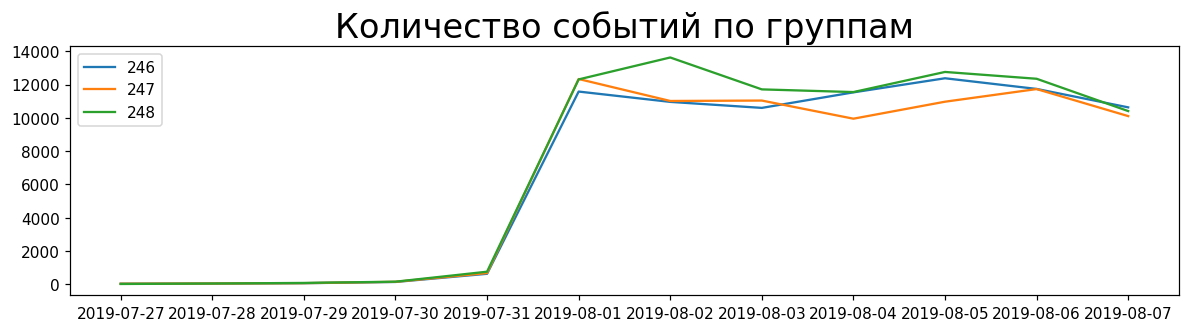

In [74]:
users_3_group = prod_real.pivot_table(index=['date'], columns=['exp_id'], values='device_id_hash', aggfunc = 'count').reset_index()
users_3_group.columns = ['date', 'g_246', 'g_247', 'g_248']
users_3_group

plt.figure(figsize=(13, 3), dpi=110)

plt.plot(users_3_group['date'], users_3_group['g_246'], label='246')
plt.plot(users_3_group['date'], users_3_group['g_247'], label='247')
plt.plot(users_3_group['date'], users_3_group['g_248'], label='248')
plt.title("Количество событий по группам", fontsize=22)
plt.legend()

In [75]:
group_246 = list(users_3_group['g_246'])
group_247 = list(users_3_group['g_247'])
alpha = .05 # критический уровень статистической значимости

results_AB = st.ttest_ind(
    group_246, 
    group_247)

bonferroni_alpha = alpha / 2  # произведено два сравнения

print('p-значение для сравнения групп 246 и 247: ', results_AB.pvalue)

if (results_AB.pvalue < bonferroni_alpha):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 247")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247")

p-значение для сравнения групп 246 и 247:  0.9373207471071892
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247


Наблюдаемые данные не подтверждают наличие разницы числа пользователей между группами.

______________________________

### 4.3.Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп и долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. То же для всех других событий. Можно ли сказать, что разбиение на группы работает корректно? <a id='104102'></a>

In [76]:
group_246 = prod_real.query('exp_id == 246')
sum_event_user_246 = group_246['device_id_hash'].count()
print('Количество уникальных событий в группе 246 - ', sum_event_user_246)
group_247 = prod_real.query('exp_id == 247')
sum_event_user_247 = group_247['device_id_hash'].count()
print('Количество уникальных событий в группе 247 - ', sum_event_user_247)
group_248 = prod_real.query('exp_id == 248')
sum_event_user_248 = group_248['device_id_hash'].count()
print('Количество уникальных событий в группе 248 - ', sum_event_user_248)

Количество уникальных событий в группе 246 -  80286
Количество уникальных событий в группе 247 -  78066
Количество уникальных событий в группе 248 -  85734


_* Число  и доля пользователей, совершивших событие MainScreenAppear в каждой из групп:_

In [77]:
users_group_main = prod_real.query('event_name =="MainScreenAppear"')
users_group_main1 = users_group_main.drop(
                        ['event_timestamp'], axis=1).groupby(
                        'exp_id', as_index=False).agg({
                        'device_id_hash' : pd.Series.nunique, 'event_name' : 'count'})
users_group_main1.columns = ['group', 'users', 'event_group']


users_group_main1['event_total'] = [80286, 78066, 85734]
users_group_main1['share_event'] = users_group_main1['event_group'] / users_group_main1['event_total']

users_group_main1

,group,users,event_group,event_total,share_event
0,246,2456,38273,80286,0.476708
1,247,2482,39705,78066,0.508608
2,248,2501,41207,85734,0.480638


_* Проверим будет ли отличие межу контрольными группами статистически достоверным:_

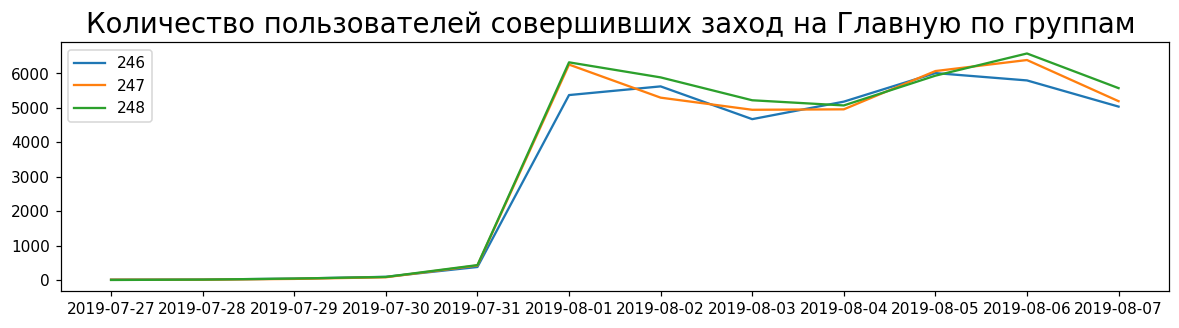

In [78]:
users_main_group = users_group_main.pivot_table(index=['date'], columns=['exp_id'], values='device_id_hash', aggfunc = 'count').reset_index()
users_main_group.columns = ['date', 'g_246', 'g_247', 'g_248']
users_main_group

plt.figure(figsize=(13, 3), dpi=110)
plt.plot(users_main_group['date'], users_main_group['g_246'], label='246')
plt.plot(users_main_group['date'], users_main_group['g_247'], label='247')
plt.plot(users_main_group['date'], users_main_group['g_248'], label='248')
plt.title("Количество пользователей совершивших заход на Главную по группам ", fontsize=18)
plt.legend()

In [79]:
group_main_246 = list(users_main_group['g_246'])
group_main_247 = list(users_main_group['g_247'])

alpha = .05 # критический уровень статистической значимости

results_AB = st.ttest_ind(
    group_main_246, 
    group_main_247)

print('p-значение для сравнения групп 246 и 247: ', results_AB.pvalue)

if (results_AB.pvalue < alpha):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 247")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247")

p-значение для сравнения групп 246 и 247:  0.9177717816758808
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247


**Наблюдаемые данные не подтверждают наличие разницы числа пользователей между контрольными группами по событию MainScreenAppear.**

_* Число и доля пользователей, совершивших событие OffersScreenAppear в каждой из групп:_

In [80]:
users_group_offers = prod_real.query('event_name =="OffersScreenAppear"')
users_group_offers1 = users_group_offers.drop(
                        ['event_timestamp'], axis=1).groupby(
                        'exp_id', as_index=False).agg({
                        'device_id_hash' : pd.Series.nunique, 'event_name' : 'count'})
users_group_offers1.columns = ['group', 'users', 'event_group']


users_group_offers1['event_total'] = [80286, 78066, 85734]
users_group_offers1['share_event'] = users_group_offers1['event_group'] / users_group_offers1['event_total']

users_group_offers1

,group,users,event_group,event_total,share_event
0,246,1545,14906,80286,0.185661
1,247,1530,15343,78066,0.196539
2,248,1538,16571,85734,0.193284


_* Проверим будет ли отличие межу контрольными группами статистически достоверным:_

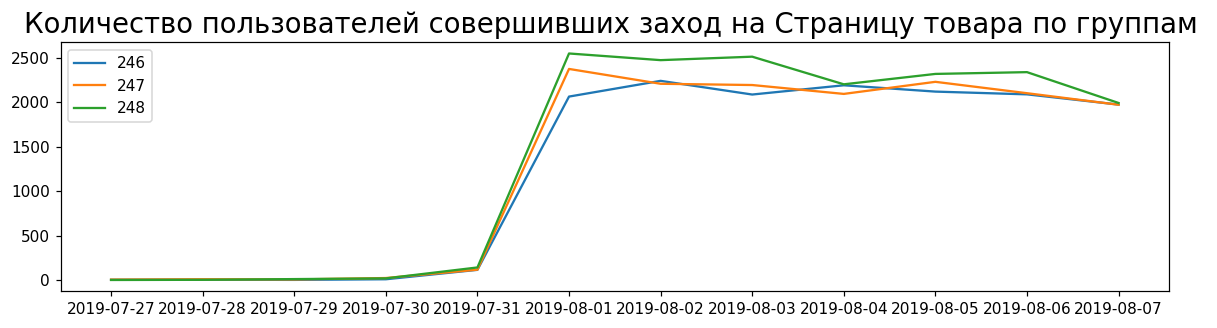

In [81]:
users_offers_group = users_group_offers.pivot_table(index=['date'], columns=['exp_id'], values='device_id_hash', aggfunc = 'count').reset_index()
users_offers_group.columns = ['date', 'g_246', 'g_247', 'g_248']
users_offers_group

plt.figure(figsize=(13, 3), dpi=110)
plt.plot(users_offers_group['date'], users_offers_group['g_246'], label='246')
plt.plot(users_offers_group['date'], users_offers_group['g_247'], label='247')
plt.plot(users_offers_group['date'], users_offers_group['g_248'], label='248')
plt.title("Количество пользователей совершивших заход на Страницу товара по группам ", fontsize=18)
plt.legend()

In [82]:
group_offers_246 = list(users_offers_group['g_246'])
group_offers_247 = list(users_offers_group['g_247'])

alpha1 = .05 # критический уровень статистической значимости

results_AB1 = st.ttest_ind(
    group_offers_246, 
    group_offers_247)

print('p-значение для сравнения групп 246 и 247: ', results_AB1.pvalue)

if (results_AB1.pvalue < alpha1):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 247")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247")

p-значение для сравнения групп 246 и 247:  0.935521349556996
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247


**Наблюдаемые данные не подтверждают наличие разницы числа пользователей между контрольными группами по событию OffersScreenAppear.**

_* Число и доля пользователей, совершивших событие CartScreenAppear в каждой из групп:_

In [83]:
users_group_cart = prod_real.query('event_name =="CartScreenAppear"')
users_group_cart1 = users_group_cart.drop(
                        ['event_timestamp'], axis=1).groupby(
                        'exp_id', as_index=False).agg({
                        'device_id_hash' : pd.Series.nunique, 'event_name' : 'count'})
users_group_cart1.columns = ['group', 'users', 'event_group']


users_group_cart1['event_total'] = [80286, 78066, 85734]
users_group_cart1['share_event'] = users_group_cart1['event_group'] / users_group_cart1['event_total']

users_group_cart1

,group,users,event_group,event_total,share_event
0,246,1270,14815,80286,0.184528
1,247,1240,12569,78066,0.161005
2,248,1239,15339,85734,0.178914


_* Проверим будет ли отличие межу контрольными группами статистически достоверным:_

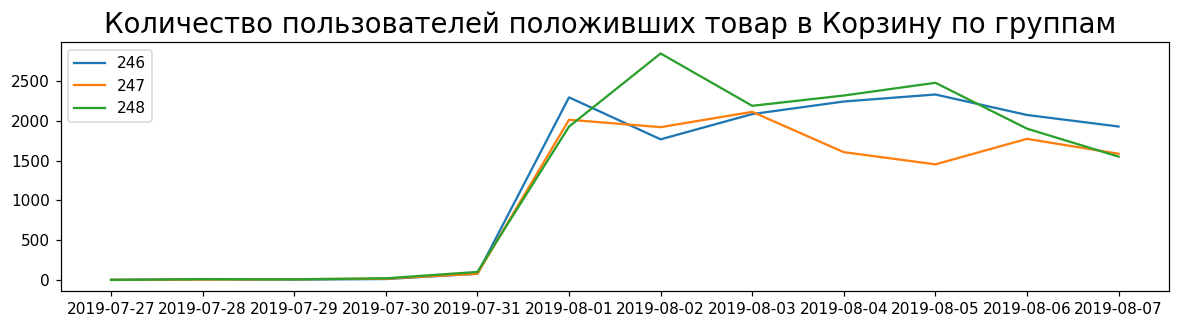

In [84]:
users_cart_group = users_group_cart.pivot_table(index=['date'], columns=['exp_id'], values='device_id_hash', aggfunc = 'count').reset_index()
users_cart_group.columns = ['date', 'g_246', 'g_247', 'g_248']
users_cart_group = users_cart_group.fillna(0)
users_cart_group

plt.figure(figsize=(13, 3), dpi=110)
plt.plot(users_cart_group['date'], users_cart_group['g_246'], label='246')
plt.plot(users_cart_group['date'], users_cart_group['g_247'], label='247')
plt.plot(users_cart_group['date'], users_cart_group['g_248'], label='248')
plt.title("Количество пользователей положивших товар в Корзину по группам ", fontsize=18)
plt.legend()

In [85]:
group_cart_246 = list(users_cart_group['g_246'])
group_cart_247 = list(users_cart_group['g_247'])

alpha2 = .05 # критический уровень статистической значимости

results_AB2 = st.ttest_ind(
    group_cart_246, 
    group_cart_247)

print('p-значение для сравнения групп 246 и 247: ', results_AB2.pvalue)

if (results_AB2.pvalue < alpha2):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 247")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247")

p-значение для сравнения групп 246 и 247:  0.6529407836216559
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247


**Наблюдаемые данные не подтверждают наличие разницы числа пользователей между группами по событию CartScreenAppear.**

_* Число и доля пользователей, совершивших событие PaymentScreenSuccessful в каждой из групп:_

In [86]:
users_group_pay = prod_real.query('event_name =="PaymentScreenSuccessful"')
users_group_pay1 = users_group_pay.drop(
                        ['event_timestamp'], axis=1).groupby(
                        'exp_id', as_index=False).agg({
                        'device_id_hash' : pd.Series.nunique, 'event_name' : 'count'})
users_group_pay1.columns = ['group', 'users', 'event_group']


users_group_pay1['event_total'] = [80286, 78066, 85734]
users_group_pay1['share_event'] = users_group_pay1['event_group'] / users_group_pay1['event_total']

users_group_pay1

,group,users,event_group,event_total,share_event
0,246,1202,11968,80286,0.149067
1,247,1160,10101,78066,0.129391
2,248,1185,12239,85734,0.142755


_* Проверим будет ли отличие межу контрольными группами статистически достоверным:_

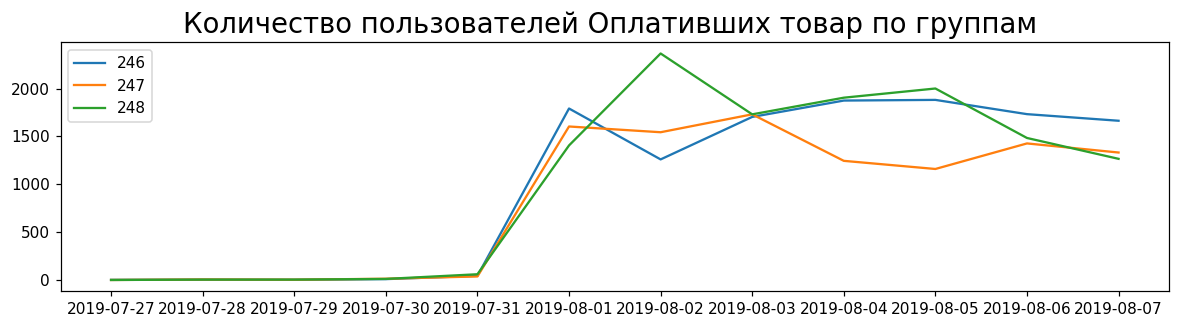

In [87]:
users_pay_group = users_group_pay.pivot_table(index=['date'], columns=['exp_id'], values='device_id_hash', aggfunc = 'count').reset_index()
users_pay_group.columns = ['date', 'g_246', 'g_247', 'g_248']
users_pay_group = users_pay_group.fillna(0)
users_pay_group

plt.figure(figsize=(13, 3), dpi=110)
plt.plot(users_pay_group['date'], users_pay_group['g_246'], label='246')
plt.plot(users_pay_group['date'], users_pay_group['g_247'], label='247')
plt.plot(users_pay_group['date'], users_pay_group['g_248'], label='248')
plt.title("Количество пользователей Оплативших товар по группам ", fontsize=18)
plt.legend()

**Видна взаимосвязь между людьми положившими товар в корзину и оплатившими его впоследствии. Так же видно, что в 248 группе количество людей совершивших эти 2 действия выше со 2 по 5 августа.**

In [88]:
group_pay_246 = list(users_pay_group['g_246'])
group_pay_247 = list(users_pay_group['g_247'])

alpha3 = .05 # критический уровень статистической значимости

results_AB3 = st.ttest_ind(
    group_pay_246, 
    group_pay_247)

print('p-значение для сравнения групп 246 и 247: ', results_AB3.pvalue)

if (results_AB3.pvalue < alpha3):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 247")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247")

p-значение для сравнения групп 246 и 247:  0.6462696428293492
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247


**Наблюдаемые данные не подтверждают наличие разницы числа пользователей между группами по событию PaymentScreenSuccessful.**

_* Число и доля пользователей, совершивших событие Tutorial в каждой из групп:_

In [89]:
users_group_t = prod_real.query('event_name =="Tutorial"')
users_group_t1 = users_group_t.drop(
                        ['event_timestamp'], axis=1).groupby(
                        'exp_id', as_index=False).agg({
                        'device_id_hash' : pd.Series.nunique, 'event_name' : 'count'})
users_group_t1.columns = ['group', 'users', 'event_group']


users_group_t1['event_total'] = [80286, 78066, 85734]
users_group_t1['share_event'] = users_group_t1['event_group'] / users_group_t1['event_total']

users_group_t1

,group,users,event_group,event_total,share_event
0,246,279,324,80286,0.004036
1,247,285,348,78066,0.004458
2,248,282,378,85734,0.004409


_* Проверим будет ли отличие межу контрольными группами статистически достоверным:_

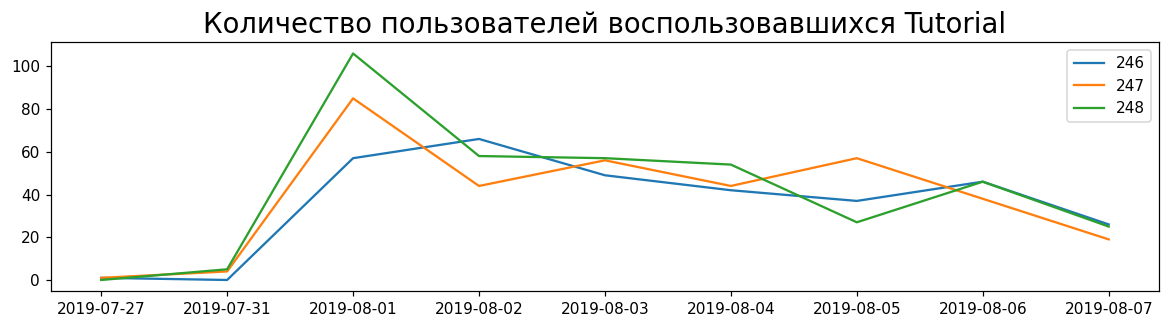

In [90]:
users_t_group = users_group_t.pivot_table(index=['date'], columns=['exp_id'], values='device_id_hash', aggfunc = 'count').reset_index()
users_t_group.columns = ['date', 'g_246', 'g_247', 'g_248']
users_t_group = users_t_group.fillna(0)
users_t_group

plt.figure(figsize=(13, 3), dpi=110)
plt.plot(users_t_group['date'], users_t_group['g_246'], label='246')
plt.plot(users_t_group['date'], users_t_group['g_247'], label='247')
plt.plot(users_t_group['date'], users_t_group['g_248'], label='248')
plt.title("Количество пользователей воспользовавшихся Tutorial", fontsize=18)
plt.legend()

**График по этому действию совершенно не совпадает с остальными событиями.**

In [91]:
group_t_246 = list(users_t_group['g_246'])
group_t_247 = list(users_t_group['g_247'])

alpha4 = .05 # критический уровень статистической значимости

results_AB4 = st.ttest_ind(
    group_t_246, 
    group_t_247)

print('p-значение для сравнения групп 246 и 247: ', results_AB4.pvalue)

if (results_AB4.pvalue < alpha4):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 247")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247")

p-значение для сравнения групп 246 и 247:  0.8248483195161718
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 247


**Наблюдаемые данные не подтверждают наличие разницы числа пользователей между контрольными группами по событию Tutorial.**

Контрольные группы равны по всем событиям, но группа по событию Tuturial намного меньше, чем другие события.

______________________________

### 4.4.Аналогично для 248 группы. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию. Сравним результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать? <a id='104103'></a>

_Сравним экспериментальную группу с контрольными по событию MainScreenAppear:_

In [92]:
group_main_248 = list(users_main_group['g_248'])
alpha = .05 # критический уровень статистической значимости

results_BC = st.ttest_ind(
    group_main_247, 
    group_main_248)

results_AC = st.ttest_ind(
    group_main_246, 
    group_main_248)

bonferroni_alpha = alpha / 2  # произведено два сравнения

print('p-значение для сравнения групп 247 и 248: ', results_BC.pvalue)
print('p-значение для сравнения групп 246 и 248: ', results_AC.pvalue)


if (results_BC.pvalue < bonferroni_alpha):
    print("Отвергаем нулевую гипотезу для сравнения групп 247 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248")

if (results_AC.pvalue < bonferroni_alpha):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248")

p-значение для сравнения групп 247 и 248:  0.9169468144676323
p-значение для сравнения групп 246 и 248:  0.8354092260627971
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248


_Сравним экспериментальную группу с контрольными по событию OffersScreenAppear:_

In [93]:
group_offers_248 = list(users_offers_group['g_248'])
alpha1 = .05 # критический уровень статистической значимости

results_BC1 = st.ttest_ind(
    group_offers_247, 
    group_offers_248)

results_AC1 = st.ttest_ind(
    group_offers_246, 
    group_offers_248)

bonferroni_alpha1 = alpha1 / 2  # произведено два сравнения

print('p-значение для сравнения групп 247 и 248: ', results_BC1.pvalue)
print('p-значение для сравнения групп 246 и 248: ', results_AC1.pvalue)

if (results_BC1.pvalue < bonferroni_alpha1):
    print("Отвергаем нулевую гипотезу для сравнения групп 247 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248")

if (results_AC1.pvalue < bonferroni_alpha1):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248")

p-значение для сравнения групп 247 и 248:  0.8297381637477284
p-значение для сравнения групп 246 и 248:  0.768001739467751
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248


_Сравним экспериментальную группу с контрольными по событию CartScreenAppear:_

In [94]:
group_cart_248 = list(users_cart_group['g_248'])
alpha2 = .05 # критический уровень статистической значимости

results_BC2 = st.ttest_ind(
    group_cart_247, 
    group_cart_248)

results_AC2 = st.ttest_ind(
    group_cart_246, 
    group_cart_248)

bonferroni_alpha2 = alpha2 / 2  # произведено два сравнения

print('p-значение для сравнения групп 247 и 248: ', results_BC2.pvalue)
print('p-значение для сравнения групп 246 и 248: ', results_AC2.pvalue)

if (results_BC2.pvalue < bonferroni_alpha2):
    print("Отвергаем нулевую гипотезу для сравнения групп 247 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248")

if (results_AC2.pvalue < bonferroni_alpha2):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248")

p-значение для сравнения групп 247 и 248:  0.592581811371084
p-значение для сравнения групп 246 и 248:  0.9244751425486712
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248


_Сравним экспериментальную группу с контрольными по событию PaymentScreenAppear:_

In [95]:
group_pay_248 = list(users_pay_group['g_248'])
alpha3 = .05 # критический уровень статистической значимости

results_BC3 = st.ttest_ind(
    group_pay_247, 
    group_pay_248)

results_AC3 = st.ttest_ind(
    group_pay_246, 
    group_pay_248)

bonferroni_alpha3 = alpha3 / 2  # произведено два сравнения

print('p-значение для сравнения групп 247 и 248: ', results_BC3.pvalue)
print('p-значение для сравнения групп 246 и 248: ', results_AC3.pvalue)

if (results_BC3.pvalue < bonferroni_alpha3):
    print("Отвергаем нулевую гипотезу для сравнения групп 247 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248")

if (results_AC3.pvalue < bonferroni_alpha3):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248")

p-значение для сравнения групп 247 и 248:  0.6105060936972274
p-значение для сравнения групп 246 и 248:  0.9519640880523486
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248


_Сравним экспериментальную группу с контрольными по событию Tutorial:_

In [96]:
group_t_248 = list(users_t_group['g_248'])
alpha4 = .05 # критический уровень статистической значимости

results_BC4 = st.ttest_ind(
    group_t_247, 
    group_t_248)

results_AC4 = st.ttest_ind(
    group_t_246, 
    group_t_248)

bonferroni_alpha4 = alpha4 / 2  # произведено два сравнения

print('p-значение для сравнения групп 247 и 248: ', results_BC4.pvalue)
print('p-значение для сравнения групп 246 и 248: ', results_AC4.pvalue)

if (results_BC4.pvalue < bonferroni_alpha4):
    print("Отвергаем нулевую гипотезу для сравнения групп 247 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248")

if (results_AC4.pvalue < bonferroni_alpha4):
    print("Отвергаем нулевую гипотезу для сравнения групп 246 и 248")
else:
    print("Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248")

p-значение для сравнения групп 247 и 248:  0.8155964393634034
p-значение для сравнения групп 246 и 248:  0.6568961738491498
Не получилось отвергнуть нулевую гипотезу для сравнения групп 247 и 248
Не получилось отвергнуть нулевую гипотезу для сравнения групп 246 и 248


Все группы не отличаются друг от друга.

_____________________

## 5.Выводы. <a id='100105'></a>

**Ранее был выбран уровень статистической значимости 0,05, но мы совершили всего 15 проверок статистических гипотез. Возьмем уровень статистической значимости - 0.15. Ничего в выводах не изменилось. Существенных отличий в группах нет. Следовательно, можно сделать вывод, что использование другого шрифта ни на что не повлиял.**

**Описание данных и, что еще мы обнаружили:**
* **Уникальных пользователей - 7551.**
* **5 видов произошедших событий, одно из которых (Tutorial) не вписывается в логическую цепочку действий, уточнить зачем оо было включено, и возможно, исследовать подробнее.**
* **В среднем, приходится 32 события на одного пользователя.**
* **Первая дата 04:43:36 25 июля 2019 года последняя - 21:15:17 7 августа 2019 года. Наиболее распространенное событие main screen appear (посещение главной страницы) таких событий 119205 - 49% от всех событий. С 1 авуста 2019 наблюдается резкий приток пользователей на сайт во всех группах. Причем первое событие - заход на Главную страницу в лидерах, возможно это старт рекламной кампании. Уточнить, что конкретно произошло. Возможно переделать срез по датам?**
* **Наибольшие потери происходят на этапе перехода/поиска товара - 39,3%. Возможно есть трудности с поиском товара на сайте. Обратить внимание коллег!**
* **28,8% пользователей доходят до оплаты после захода на Главную страницу.**